In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
%matplotlib inline
import matplotlib 
matplotlib.rcParams["font.size"] = 14

In [2]:
eta, tau, c = 0.1, 0.01, 0.5
cs, ncx, ncz, npad = 10., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 1e-3
airind = mesh.gridCC[:,2]>0.
layerind = (np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)) & (mesh.gridCC[:,0]<100.)
# layerind = np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)
sigmaInf[airind] = 1e-8
sigmaInf[layerind] = 0.01
# sigmaInf[layerind] = 1e-1

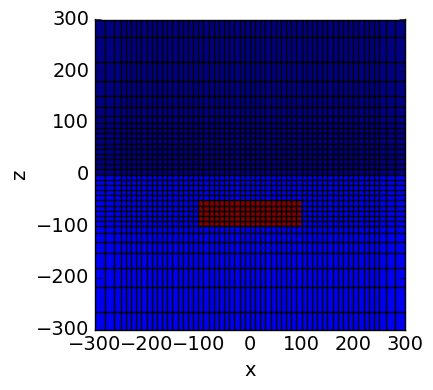

In [3]:
mesh.plotImage(sigmaInf, grid=True, mirror=True)
plt.xlim(-300, 300)
plt.ylim(-300, 300)
plt.gca().set_aspect('equal')

In [4]:
# from simpegEMIP.TDEM import Problem3D_e, BaseTDEMIPProblem
# from simpegEMIP.Base import BaseEMIPProblem

In [5]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
survey = EM.TDEM.Survey([src])
prb_em = EM.TDEM.Problem3D_e(mesh, sigma=sigmaInf)
# prb_em.verbose = True
prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
# prb_em.timeSteps = [(1e-06, 5), (5e-06, 10), (1e-05, 10), (5e-05, 10), (1e-04, 10), (5e-04, 10), (1e-03, 10)]
prb_em.Solver = PardisoSolver
prb_em.pair(survey)
F = prb_em.fields(sigmaInf)
data = survey.dpred(sigmaInf, f=F)

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


In [6]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
t0 = 0.00147
# t0 = 5e-6
rx_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+t0, 'z')
src_ramp = EM.TDEM.Src.CircularLoop([rx_ramp], waveform=EM.TDEM.Src.RampOffWaveform(offTime=t0), loc=srcloc)
survey_ramp = EM.TDEM.Survey([src_ramp])
prb_em_ramp = EM.TDEM.Problem3D_e(mesh, sigma=sigmaInf)
# prb_em_ramp.verbose = True
prb_em_ramp.timeSteps = [(t0/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em_ramp.Solver = PardisoSolver
prb_em_ramp.pair(survey_ramp)
# m = np.r_[sigmaInf, etavec, np.log(tauvec), cvec]
F_ramp = prb_em_ramp.fields(sigmaInf)
data_ramp = survey_ramp.dpred(sigmaInf, f=F_ramp)
cur = []
for t in prb_em_ramp.times:
    cur.append(src_ramp.waveform.eval(t))
cur = np.hstack(cur)

(-0.2, 1.2)

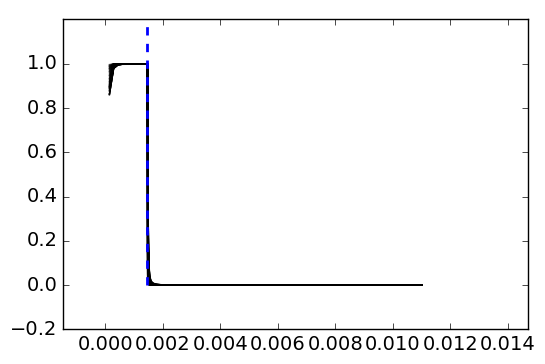

In [7]:
z = mesh.vectorCCz[np.logical_and(mesh.vectorCCz < 0., mesh.vectorCCz > -200.)]
x = mesh.vectorCCx[mesh.vectorCCx < 100.]
xyz = Utils.ndgrid(x, np.r_[0.], z)
e_ramp = F_ramp[src_ramp,'eSolution', :]
rxinds = Utils.closestPoints(mesh, pts=xyz, gridLoc='N')
for rxind in rxinds:
    plt.plot(prb_em_ramp.times[1:], e_ramp[rxind,1:].flatten() / e_ramp[rxind,1:].max(), 'k', alpha=0.2)
# plt.xscale('log')
plt.plot(np.ones(2)*t0, np.r_[0, 1.2], '--', lw=2)
plt.xlim(-t0, t0*10)
plt.ylim(-0.2, 1.2)


In [8]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
t0 = 4.2e-3
tpeak = 2.73e-3
rx_vtem = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+t0, 'z')
src_vtem = EM.TDEM.Src.CircularLoop([rx_vtem], waveform=EM.TDEM.Src.VTEMWaveform(offTime=t0, peakTime=tpeak, a=3.), loc=srcloc)
survey_vtem = EM.TDEM.Survey([src_vtem])
prb_em_vtem = EM.TDEM.Problem3D_e(mesh, sigma=sigmaInf)
# prb_em_vtem.verbose = True
prb_em_vtem.timeSteps = [(tpeak/10, 10), ((t0-tpeak)/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em_vtem.Solver = PardisoSolver
prb_em_vtem.pair(survey_vtem)
F_vtem = prb_em_vtem.fields(sigmaInf)
data_vtem = survey_vtem.dpred(sigmaInf, f=F_vtem)
cur = []
for t in prb_em_vtem.times:
    cur.append(src_vtem.waveform.eval(t))
cur = np.hstack(cur)


In [9]:
def foo(a, time, tpeak):    
    return (1. - np.exp(-a*time/tpeak)) / (1.-np.exp(-a))
#     return (1. + -a*time/tpeak) / (1.-np.exp(-a))

In [10]:
import sympy

In [11]:
prb_em_vtem.times[np.argwhere(cur>0.8)]

array([[ 0.001365],
       [ 0.001638],
       [ 0.001911],
       [ 0.002184],
       [ 0.002457],
       [ 0.00273 ],
       [ 0.002877],
       [ 0.003024]])

(0.0, 0.01)

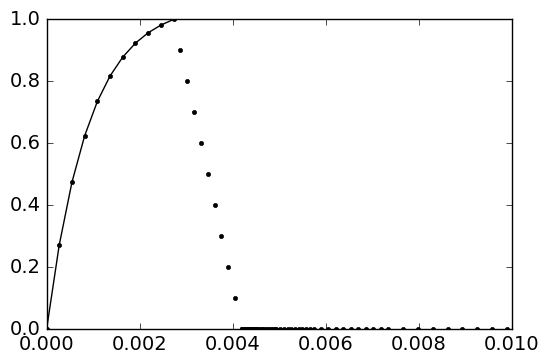

In [12]:
plt.plot(prb_em_vtem.times, cur, 'k.')
plt.plot(prb_em_vtem.times[prb_em_vtem.times<tpeak], foo(3., prb_em_vtem.times[prb_em_vtem.times<tpeak], tpeak), 'k-')
plt.xscale("linear")
plt.xlim(0., 1e-2)

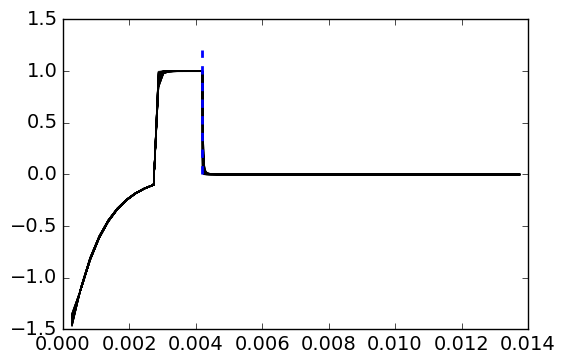

In [13]:
e_vtem = F_vtem[src_vtem,'eSolution', :]
rxinds = Utils.closestPoints(mesh, pts=xyz, gridLoc='N')
for rxind in rxinds:
    plt.plot(prb_em_vtem.times[1:], e_vtem[rxind,1:].flatten() / e_vtem[rxind,1:].max(), 'k', alpha=0.2)
# plt.xscale('log')
plt.plot(np.ones(2)*t0, np.r_[0, 1.2], '--', lw=2)
# plt.xlim(tpeak, 1e-2)
# plt.ylim(-0.2, 1.2)


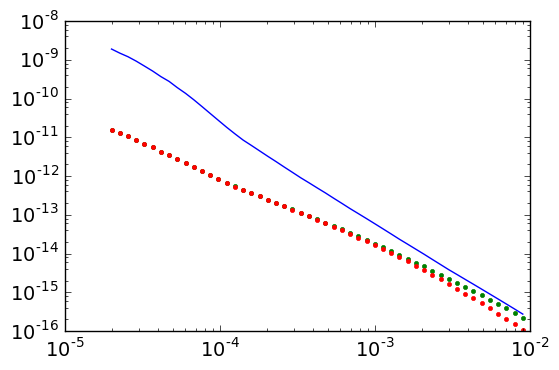

In [14]:
plt.loglog(rx.times, -data)
plt.loglog(rx.times, -data_ramp, '.')
plt.loglog(rx.times, -data_vtem, 'r.')

In [15]:
np.save('dataem', data)
np.save('dataem_ramp', data_ramp)
np.save('dataem_vtem', data_vtem)